In [1]:
import numpy as np
import pandas as pd
import os
import sys
import matplotlib.pyplot as plt
import seaborn

from itertools import islice, count
%matplotlib inline

In [2]:
import pycosmicstar.lcdmcosmology as lcdmcos

lcdmlib not imported, using pure python version of sigma


In [3]:
# import regularization module
os.chdir("/home/peregrinus/Arquivos/cap/problemas-inversos/optimization-regularization/regularization/")
import regularization as reg

# import objetive function
os.chdir("/home/peregrinus/Arquivos/cap/problemas-inversos/")
import objectivefunction as of

In [4]:
# load lcdm model
lcdmUniverser = lcdmcos.Lcdmcosmology(omegam=0.24,
                              omegab=0.04, 
                              omegal=0.73,
                               h=0.7)

In [5]:
delta_mbh = 0.1 # pass in m_bh
delta_z = 0.1 # pass in z
dz = -delta_z
dm = delta_mbh
D = dz/dm 
m0 = 7.7 # inicial mass
mf = 9.6 # final mass
z0 = 20.0 # inicial redshift
zf = 0.3 # final redshift

In [6]:
# load csv with experimental data
os.chdir("/home/peregrinus/Arquivos/cap/problemas-inversos/projeto")
df = pd.read_csv('mean_LBH.csv')

In [7]:
# find the number of points to z and m_bh to build the matrix of
# mass distribution
num_pontos_z = len(df.z.unique())
num_pontos_m = len(df.massBH.unique())

In [1]:
# preparer matrix nbh_obs
nbh_obs = np.empty((num_pontos_m, num_pontos_z))
nbh_obs.fill(np.nan)

NameError: name 'np' is not defined

In [39]:
# load data from csv to matrix
for l in range(0, df.shape[0]):
    i = int(np.around(df.z[l]*10.0, decimals=1) - 3.0)
    j = int(np.around(df.massBH[l]*10.0, decimals=1) - 77.0)
    nbh_obs[j][i] = df.nObjects[l]

In [40]:
class mbh_mean_dt(object):
    """
    This class implement the average of the varitation of m_bh in relation to time
    """
    def __init__(self, lb_mean_par, mbh_par, alpha_par, tau_par, eta, c = 3e8):
        self.__const1 = (1/c**2.0)*((1-eta)/eta)
        self.__lb_mean_par = lb_mean_par 
        self.__mbh_par = mbh_par 
        self.__alpha_par = alpha_par  
        self.__tau_par = tau_par
        
    def __call__(self, mbh, tz):
        return self.__const1 * self.__lb_mean_par * (mbh/self.__mbh_par)**self.__alpha_par * (self.__tau_par/tz) * np.exp(-tz/self.__tau_par)
    
    @property
    def alpha_par(self):
        return self.__alpha_par

In [41]:
class mbh_mean_dt_dm(object):
    """
    This class implement the derivative in relation to m_bh for the class mbh_mean_dt
    """
    def __init__(self, mbh_mean_dt):
        self.__alpha_par = mbh_mean_dt.alpha_par
        self.__mbh_mean_dt = mbh_mean_dt
    
    def __call__(self, mbh, tz):
        return (self.__alpha_par/mbh) * self.__mbh_mean_dt(mbh, tz)

In [43]:
class V(object):
    """
    """
    def __init__(self, mmt, mmtm):
        self.__mmt = mmt
        self.__mmtm = mmtm

    def __call__(self, mbh, tz, dm):
        return self.__mmtm(mbh, tz) + self.__mmt(mbh, tz)/dm

In [71]:
#        best fit         bias      error 
# lb_mean_par : 3.05e47 : 6.65e45  : 3.14e46
# mbh_par     : 2.19e11 : 1.88e10  : 4.88e10
# alpha_par   : 2.71e-1 : -1.29e-4 : 1.18e-2
# tau_par     : 4.81e9  : 1.05e7   : 1.69e8

# load the class defined above with values find by bootstrap regresssion from experimental
# data

mmt = mbh_mean_dt(3.05e7, 2.19e11, 2.71e-1, 4.81e9, 0.1)
mmtm = mbh_mean_dt_dm(mmt)
auxiliarV = V(mmt, mmtm)

In [72]:
# L is a representative function to dt/dz in z = zj
L = lambda z: lcdmUniverser.dt_dz(z)

In [73]:
# A the operator of time evolution
A = np.identity(num_pontos_m)

# the matriz At for time evolution has dependencie in time, 
# so need to be remake for each time

j = 0 # the index j represent time(redshift)
zj = dz*j + z0 # the value of the redshift in pass j

# the value of time to zj, consider the cosmologic model
tzj = lcdmUniverser.dt_dz(zj)*delta_z 

while zj > 0.2:
    At = np.zeros((num_pontos_m, num_pontos_m))
    
    lzj = L(zj)
    for i in islice(count(), 1, num_pontos_m-1):
        mi = dm*i + m0    
        if i-1 >= 0:
            At[i][i-1] = lzj*D*mmt(mi, tzj)
        At[i][i] = 1 - dz*auxiliarV(mi, tzj, dm)*lzj

    mi = dm*0 + m0
    At[0][0] = 1 - dz*L(zj)*auxiliarV(mi, tzj, dm) + lzj*D*mmtm(mi, tzj)
    mi = dm*(num_pontos_m-1) + m0
    At[num_pontos_m-1][num_pontos_m-1] = 1 - dz*L(zj)*auxiliarV(mi, tzj, dm) + lzj*D*mmtm(mi, tzj)
    
    A = np.dot(A, At)
    zj += dz
    tzj += lcdmUniverser.dt_dz(zj)*delta_z

In [74]:
# define gaussian function as initial condition,
# to avaliate the direct model
def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

In [75]:
m = np.linspace(m0, mf, num_pontos_m)

In [76]:
# generate initial test condition to evolve in time
test_initial_condition = gaussian(m, (m0+mf)/2., 1.)

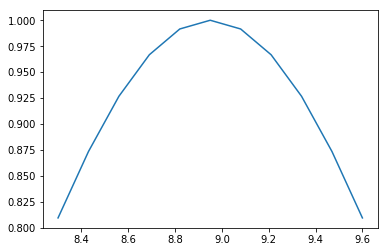

In [77]:
from matplotlib import pyplot as mp
mp.plot(m, test_initial_condition)
mp.show()

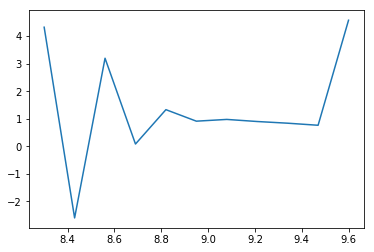

In [78]:
# evolve the initial condition using the operator A,
# for time evolution, and plot the same
test_initial_condition_evolve = A.dot(test_initial_condition)
mp.plot(m, test_initial_condition_evolve)
mp.show()

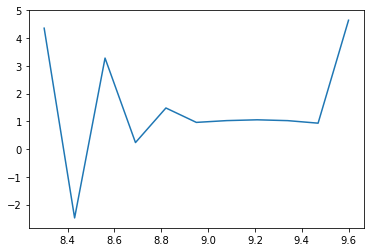

In [99]:
# add noise to the evolve configuration
sigma = 0.0
np.random.seed(seed=1234)
test_initial_condition_evolve += sigma*np.random.uniform(low=0.0, high=1.0, size=num_pontos_m)
mp.plot(m, test_initial_condition_evolve)
mp.show()

In [100]:
# load regularization, Tiknov order 0

alpha = 0
tik0 = reg.TikhonovOrder0(num_pontos_m)

J = of.FuncJ(alpha, A.dot, tik0)
Jmeasure = lambda f: J(f, test_initial_condition_evolve)

def evaluate(individual):
    return (Jmeasure(individual),)

In [101]:
from deap import algorithms
from deap import base
from deap import creator
from deap import tools

In [102]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", np.ndarray, fitness=creator.FitnessMin)

In [103]:
toolbox = base.Toolbox()

In [104]:
np.random.seed(1234)
toolbox.register("attr_float", np.random.uniform, 0., 1.)
toolbox.register("individual", 
                 tools.initRepeat,
                 creator.Individual,
                 toolbox.attr_float,
                 n=num_pontos_m)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

In [105]:
toolbox.register("evaluate", evaluate)
toolbox.register("mate", tools.cxBlend, alpha=0.5)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=6)

In [106]:
pop = toolbox.population(n=500)

In [107]:
stats = tools.Statistics(key=lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

#logbook = tools.Logbook()
#logbook.record(gen=0, evals=30, **record)

In [109]:
result, logbook = algorithms.eaSimple(pop, 
                             toolbox, 
                             cxpb=0.5, 
                             mutpb=0.5, 
                             ngen=200, 
                             stats=stats, verbose=True)

gen	nevals	avg    	std    	min    	max    
0  	0     	140.038	307.418	1.27614	2858.23
1  	370   	179.702	381.209	1.27614	2826   
2  	364   	187.792	386.824	1.27429	3153.26
3  	387   	151.708	318.959	1.27386	2538.98
4  	391   	164.213	334.123	1.27134	2495.27
5  	375   	164.266	337.792	1.27134	2648.98
6  	387   	194.07 	370.315	1.26732	2600.49
7  	389   	176.674	378.25 	1.26419	3171.9 
8  	367   	215.562	451.072	1.25954	3539.74
9  	356   	188.537	428.853	1.25858	4920.46
10 	354   	165.954	359.127	1.25765	2653.12
11 	379   	161.946	312.898	1.25444	2070.31
12 	389   	154.374	302.179	1.25307	2451.89
13 	394   	174.51 	345.888	1.25308	2528.87
14 	370   	166.958	318.964	1.24655	2563   
15 	376   	151.308	295.078	1.24424	2841.42
16 	378   	170.155	352.326	1.23992	4307.76
17 	346   	203.419	418.492	1.23959	3189.44
18 	355   	183.503	373.041	1.23868	3014.03
19 	395   	179.866	419.981	1.23604	5616.86
20 	383   	172.17 	334.867	1.23423	2435.37
21 	363   	177.5  	382.547	1.2312 	3477.33
22 	375   	

192	371   	172.064	354.515	0.964705	3186.82
193	353   	186.535	453.963	0.961377	5535.76
194	380   	144.553	304.543	0.961377	2537.64
195	360   	161.838	397.403	0.959562	3641.42
196	360   	157.38 	345.32 	0.959135	3085.09
197	376   	183.511	440.887	0.957397	4038.53
198	383   	164.412	328.24 	0.957397	2601.88
199	372   	174.87 	382.295	0.955479	2888.57
200	377   	159.294	326.842	0.954382	2383.87


In [110]:
best = tools.selBest(pop, k=1)[0]
print('Current best fitness:', evaluate(best))

('Current best fitness:', (0.95438222899542446,))


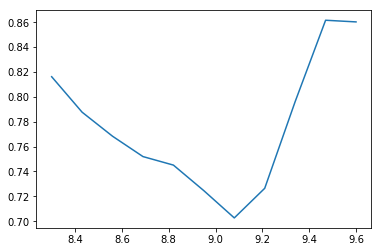

In [111]:
mp.plot(m, best)
mp.show()

# Make a new avaliation of the direct method, using the evolve operator in the experimental data

In [95]:
num_pontos_m = 11
A = np.identity(num_pontos_m)

# the matriz At for time evolution has dependencie in time, so need to be remake for each time
j = 0
zj = dz*j + z0
tzj = lcdmUniverser.dt_dz(zj)*delta_z
m0 = 8.3


while zj > 1.5:
    At = np.zeros((num_pontos_m, num_pontos_m))
    
    lzj = L(zj)
    for i in islice(count(), 1, num_pontos_m-1):
        mi = dm*i + m0    
        if i-1 >= 0:
            At[i][i-1] = lzj*D*mmt(mi, tzj)
        At[i][i] = 1 - dz*auxiliarV(mi, tzj, dm)*lzj

    mi = dm*0 + m0
    At[0][0] = 1 - dz*L(zj)*auxiliarV(mi, tzj, dm) + lzj*D*mmtm(mi, tzj)
    mi = dm*(num_pontos_m-1) + m0
    At[num_pontos_m-1][num_pontos_m-1] = 1 - dz*L(zj)*auxiliarV(mi, tzj, dm) + lzj*D*mmtm(mi, tzj)
    
    A = np.dot(A, At)
    zj += dz
    tzj += lcdmUniverser.dt_dz(zj)*delta_z

In [96]:
mbh_83_94_t12 = nbh_obs[12][6:17]
mbh_83_94_t13 = (nbh_obs[13][6:17])

In [97]:
A.dot(mbh_83_94_t13)

array([ 1230.76909852,  -418.22761216,  1029.81271423,    36.06586584,
         433.02775572,   571.09704014,   312.04771434,   138.65358202,
         432.45023275,    20.55861962,  1144.28206162])

In [98]:
print(np.abs(mbh_83_94_t12-A.dot(mbh_83_94_t13))/mbh_83_94_t12)

[ 4.04413565  2.27508418  2.09253067  0.90508983  0.27736801  0.7253687
  0.14036442  0.44091298  0.68925872  0.89292386  6.02013535]


In [70]:
# error 
print(np.abs(mbh_83_94_t12-A.dot(mbh_83_94_t13)))

[  45.88592272    9.16155551   67.19968207   19.52412792   32.37403656
   76.03865356   54.69602909  100.13898267   62.81769162   66.93082191
   93.63690416]
